In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, BayesianRidge, HuberRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, BaggingRegressor, ExtraTreesRegressor, AdaBoostRegressor, VotingRegressor
from sklearn.svm import SVR

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from scipy.stats import randint, uniform


# Data preparation

## Import

In [13]:
flights = pd.read_csv("data/flights.csv", low_memory=False)
airports = pd.read_csv("data/airports.csv", low_memory=False)

airports.info()
flights.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 322 entries, 0 to 321
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   IATA_CODE  322 non-null    object 
 1   AIRPORT    322 non-null    object 
 2   CITY       322 non-null    object 
 3   STATE      322 non-null    object 
 4   COUNTRY    322 non-null    object 
 5   LATITUDE   319 non-null    float64
 6   LONGITUDE  319 non-null    float64
dtypes: float64(2), object(5)
memory usage: 17.7+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5819079 entries, 0 to 5819078
Data columns (total 31 columns):
 #   Column               Dtype  
---  ------               -----  
 0   YEAR                 int64  
 1   MONTH                int64  
 2   DAY                  int64  
 3   DAY_OF_WEEK          int64  
 4   AIRLINE              object 
 5   FLIGHT_NUMBER        int64  
 6   TAIL_NUMBER          object 
 7   ORIGIN_AIRPORT       object 
 8   DESTINATION_AIRPORT  obje

## Cleanup missing data

In [14]:
flights_cleaned = flights[flights["CANCELLED"] == 0]

features = [ 
    "MONTH","DAY","DAY_OF_WEEK","AIRLINE","FLIGHT_NUMBER","TAIL_NUMBER",
    "ORIGIN_AIRPORT","DESTINATION_AIRPORT","SCHEDULED_DEPARTURE","DEPARTURE_TIME","DEPARTURE_DELAY",
    "TAXI_OUT","WHEELS_OFF","SCHEDULED_TIME","ELAPSED_TIME","AIR_TIME","DISTANCE","WHEELS_ON","TAXI_IN",
    "SCHEDULED_ARRIVAL","ARRIVAL_TIME","ARRIVAL_DELAY",
    "AIR_SYSTEM_DELAY","SECURITY_DELAY","AIRLINE_DELAY","LATE_AIRCRAFT_DELAY","WEATHER_DELAY"
]
flights_cleaned = flights_cleaned[features]
missing_data = [
    "AIR_SYSTEM_DELAY", "SECURITY_DELAY", "AIRLINE_DELAY",
    "LATE_AIRCRAFT_DELAY", "WEATHER_DELAY"
]
flights_cleaned[missing_data] = flights_cleaned[missing_data].fillna(0)

## Enhance data with airport info

In [15]:
airports.rename(columns={"IATA_CODE": "ORIGIN_AIRPORT"}, inplace=True)
flights_enhanced = flights_cleaned.merge(airports[["ORIGIN_AIRPORT", "LATITUDE", "LONGITUDE", "STATE", "CITY"]],
                        on="ORIGIN_AIRPORT", how="left")
flights_enhanced.rename(columns={"LATITUDE": "ORIGIN_LAT", "LONGITUDE": "ORIGIN_LON", "STATE": "ORIGIN_STATE", "CITY": "ORIGIN_CITY"}, inplace=True)

airports.rename(columns={"ORIGIN_AIRPORT": "DESTINATION_AIRPORT"}, inplace=True)
flights_enhanced = flights_enhanced.merge(airports[["DESTINATION_AIRPORT", "LATITUDE", "LONGITUDE", "STATE", "CITY"]],
                        on="DESTINATION_AIRPORT", how="left")
flights_enhanced.rename(columns={"LATITUDE": "DEST_LAT", "LONGITUDE": "DEST_LON", "STATE": "DEST_STATE", "CITY": "DEST_CITY"}, inplace=True)

flights_enhanced.dropna(inplace=True)

## Drop non numeric

In [16]:
categorical = flights_enhanced.select_dtypes(include=["object", "category"]).columns.tolist()

flights_final = flights_enhanced.drop(columns=categorical)
flights_final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5222000 entries, 0 to 5729194
Data columns (total 27 columns):
 #   Column               Dtype  
---  ------               -----  
 0   MONTH                int64  
 1   DAY                  int64  
 2   DAY_OF_WEEK          int64  
 3   FLIGHT_NUMBER        int64  
 4   SCHEDULED_DEPARTURE  int64  
 5   DEPARTURE_TIME       float64
 6   DEPARTURE_DELAY      float64
 7   TAXI_OUT             float64
 8   WHEELS_OFF           float64
 9   SCHEDULED_TIME       float64
 10  ELAPSED_TIME         float64
 11  AIR_TIME             float64
 12  DISTANCE             int64  
 13  WHEELS_ON            float64
 14  TAXI_IN              float64
 15  SCHEDULED_ARRIVAL    int64  
 16  ARRIVAL_TIME         float64
 17  ARRIVAL_DELAY        float64
 18  AIR_SYSTEM_DELAY     float64
 19  SECURITY_DELAY       float64
 20  AIRLINE_DELAY        float64
 21  LATE_AIRCRAFT_DELAY  float64
 22  WEATHER_DELAY        float64
 23  ORIGIN_LAT           float64
 24  ORI

## Corelation matrix

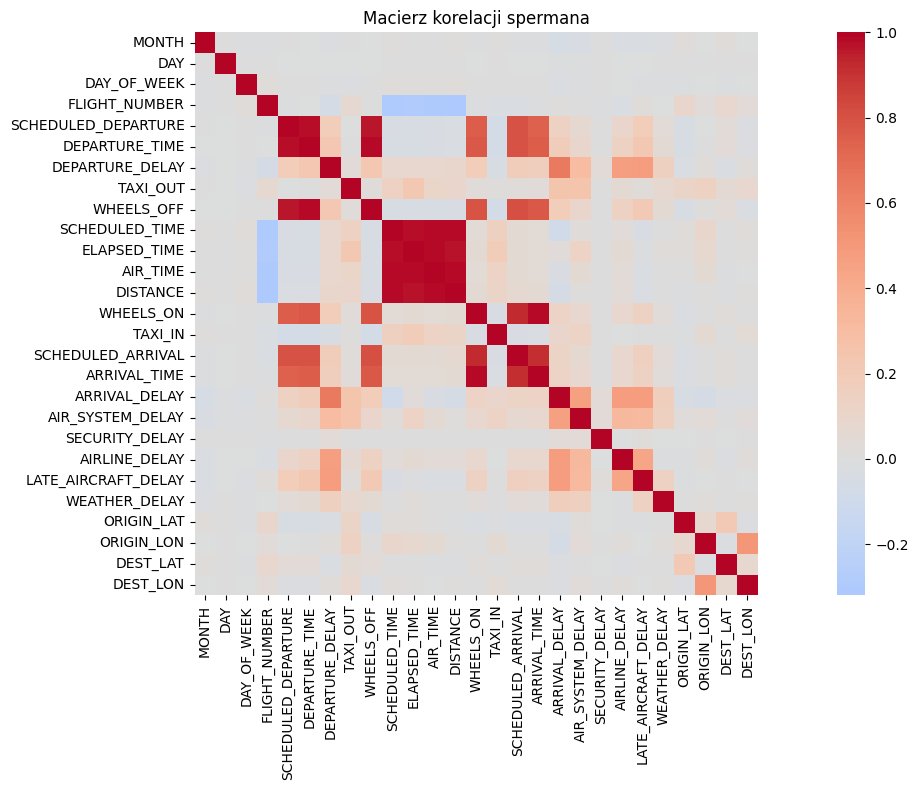

In [17]:
corr = flights_final.corr(method='spearman', min_periods=2)

plt.figure(figsize=(max(10, len(flights_final.columns) * 0.6), 8))
sns.heatmap(corr, annot=False, cmap='coolwarm', center=0, fmt=".2f", square=True)
plt.title(f'Macierz korelacji spermana')
plt.tight_layout()
plt.show()

# Model

## Linear Regression

In [ ]:
target = "ARRIVAL_DELAY"

y = flights_final[target]
X = flights_final.drop(columns=[target])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
y_pred = lr_model.predict(X_test)
r2 = r2_score(y_test, y_pred)
print(f"R^2 score = {r2:.4f}")
mae = mean_absolute_error(y_test, y_pred)
print(f"MAE score = {mae:.4f}")
rmse = mean_squared_error(y_test, y_pred)
print(f"RMSE score = {rmse:.4f}")

0.9999999999999839
0.9999999999999839


## Filter out trivial data

In [7]:
flights_sample = flights_final.sample(n=10000, random_state=42)
easy_features = [ 
    "DEPARTURE_DELAY",
    "ELAPSED_TIME","AIR_TIME","WHEELS_ON","TAXI_IN",
    "ARRIVAL_TIME",
    "AIR_SYSTEM_DELAY","SECURITY_DELAY","AIRLINE_DELAY","LATE_AIRCRAFT_DELAY","WEATHER_DELAY"
]

target = "ARRIVAL_DELAY"

y = flights_sample[target]
X = flights_sample.drop(columns=[target])
X = X.drop(columns=easy_features)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

## Algorithm ranking 

In [ ]:
models = [
    ('LinearRegression', make_pipeline(StandardScaler(), LinearRegression())),
    ('Ridge', make_pipeline(StandardScaler(), Ridge())),
    ('Lasso', make_pipeline(StandardScaler(), Lasso())),
    ('ElasticNet', make_pipeline(StandardScaler(), ElasticNet())),
    ('BayesianRidge', make_pipeline(StandardScaler(), BayesianRidge())),
    ('HuberRegressor', make_pipeline(StandardScaler(), HuberRegressor())),
    ('DecisionTreeRegressor', DecisionTreeRegressor()),
    ('RandomForestRegressor', RandomForestRegressor()),
    ('GradientBoostingRegressor', GradientBoostingRegressor()),
    ('BaggingRegressor', BaggingRegressor(DecisionTreeRegressor())),
    ('ExtraTreesRegressor', ExtraTreesRegressor()),
    ('AdaBoostRegressor', AdaBoostRegressor()),
    ('SVR', make_pipeline(StandardScaler(), SVR())),
    ('KNeighborsRegressor', make_pipeline(StandardScaler(), KNeighborsRegressor())),
    ('GaussianProcessRegressor', make_pipeline(StandardScaler(), GaussianProcessRegressor())),
    ('MLPRegressor', make_pipeline(StandardScaler(), MLPRegressor())),
]

results = []
for name, model in models:
    try:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        score = r2_score(y_test, y_pred)
        print(f"{name}: R^2 score = {score:.4f}")
        results.append((name, score))
    except Exception as e:
        print(f"{name}: Error - {e}")

print("\nSorted Results:")
for name, score in sorted(results, key=lambda x: x[1], reverse=True):
    print(f"{name}: R^2 score = {score:.4f}")

## Voting approach

In [ ]:
model_voting =  VotingRegressor([
        ('er', ExtraTreesRegressor()),
        ('rf', RandomForestRegressor()),
        ('gb', GradientBoostingRegressor()),
        ('mlp', make_pipeline(StandardScaler(), MLPRegressor())),
        ('bg', BaggingRegressor(DecisionTreeRegressor()))
    ])

model_voting.fit(X_train, y_train)
y_pred = model_voting.predict(X_test)
score = r2_score(y_test, y_pred)
print(f"{name}: R^2 score = {score:.4f}")

## Automatic algorithm search

In [ ]:
from tpot import TPOTRegressor

tpot = TPOTRegressor(generations=5, population_size=50, verbosity=2, random_state=42)
tpot.fit(X_train, y_train)
print(tpot.score(X_test, y_test))

## Hyperparameter grid search

In [ ]:
models = {
    "ExtraTreesRegressor": ExtraTreesRegressor(random_state=42),
    "RandomForestRegressor": RandomForestRegressor(random_state=42),
    "GradientBoostingRegressor": GradientBoostingRegressor(random_state=42),
    "BaggingRegressor": BaggingRegressor(random_state=42),
}

### Manual search

In [ ]:
param_grids = {
    "ExtraTreesRegressor": {
        "n_estimators": [100, 200, 300],
        "max_depth": [None, 10, 30, 50],
        "min_samples_split": [2, 5, 10],
        "min_samples_leaf": [1, 2, 4]
    },
    "RandomForestRegressor": {
        "n_estimators": [100, 200, 300],
        "max_depth": [None, 10, 30, 50],
        "min_samples_split": [2, 5, 10],
        "min_samples_leaf": [1, 2, 4]
    },
    "GradientBoostingRegressor": {
        "n_estimators": [100, 200],
        "learning_rate": [0.01, 0.05, 0.1],
        "max_depth": [3, 5, 10],
        "subsample": [0.8, 1.0]
    },
    "BaggingRegressor": {
        "n_estimators": [10, 20, 50, 100],
        "max_samples": [0.5, 0.8, 1.0],
        "max_features": [0.5, 0.8, 1.0]
    }
}

for name, model in models.items():
    print(f"\nTuning {name}...")
    param_grid = param_grids[name]
    grid = GridSearchCV(model, param_grid, cv=3, scoring='r2', n_jobs=-1, verbose=2)
    grid.fit(X_train, y_train)
    best_estimator = grid.best_estimator_
    y_pred = best_estimator.predict(X_test)
    score = r2_score(y_test, y_pred)
    print(f"Best parameters for {name}: {grid.best_params_}")
    print(f"Test R^2 score for {name}: {score:.4f}")

### Random search

In [ ]:
param_dists = {
    "ExtraTreesRegressor": {
        "n_estimators": randint(100, 500),
        "max_depth": [None] + list(range(10, 51, 10)),
        "min_samples_split": randint(2, 11),
        "min_samples_leaf": randint(1, 5)
    },
    "RandomForestRegressor": {
        "n_estimators": randint(100, 500),
        "max_depth": [None] + list(range(10, 51, 10)),
        "min_samples_split": randint(2, 11),
        "min_samples_leaf": randint(1, 5)
    },
    "GradientBoostingRegressor": {
        "n_estimators": randint(100, 400),
        "learning_rate": uniform(0.01, 0.19),
        "max_depth": randint(3, 11),
        "subsample": uniform(0.7, 0.3)
    },
    "BaggingRegressor": {
        "n_estimators": randint(10, 101),
        "max_samples": uniform(0.5, 0.5),
        "max_features": uniform(0.5, 0.5)
    }
}

n_iter_search = 30

for name, model in models.items():
    print(f"\nRandomized search for {name}...")
    search = RandomizedSearchCV(
        model,
        param_distributions=param_dists[name],
        n_iter=n_iter_search,
        scoring='r2',
        n_jobs=-1,
        cv=3,
        verbose=2,
        random_state=42
    )
    search.fit(X_train, y_train)
    best_model = search.best_estimator_
    y_pred = best_model.predict(X_test)
    score = r2_score(y_test, y_pred)
    print(f"Best parameters for {name}: {search.best_params_}")
    print(f"Test R^2 score for {name}: {score:.4f}")


Randomized search for ExtraTreesRegressor...
Fitting 3 folds for each of 30 candidates, totalling 90 fits
Best parameters for ExtraTreesRegressor: {'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 413}
Test R^2 score for ExtraTreesRegressor: 0.8068

Randomized search for RandomForestRegressor...
Fitting 3 folds for each of 30 candidates, totalling 90 fits
Best parameters for RandomForestRegressor: {'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 413}
Test R^2 score for RandomForestRegressor: 0.7428

Randomized search for GradientBoostingRegressor...
Fitting 3 folds for each of 30 candidates, totalling 90 fits
Best parameters for GradientBoostingRegressor: {'learning_rate': np.float64(0.18832501471299254), 'max_depth': 4, 'n_estimators': 291, 'subsample': np.float64(0.9976634677873653)}
Test R^2 score for GradientBoostingRegressor: 0.7640

Randomized search for BaggingRegressor...
Fitting 3 folds for each of 30 candidates, 

## Final training

In [ ]:
y = flights_final[target]
X = flights_final.drop(columns=[target])
X = X.drop(columns=easy_features)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)


model = GradientBoostingRegressor(learning_rate = 0.1, max_depth = 5, n_estimators = 200, subsample = 0.8)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)
r2 = r2_score(y_test, y_pred)
print(f"R^2 score = {r2:.4f}")
mae = mean_absolute_error(y_test, y_pred)
print(f"MAE score = {mae:.4f}")
rmse = mean_squared_error(y_test, y_pred)
print(f"RMSE score = {rmse:.4f}")

R^2 score = 0.9123
MAE score = 8.0220
RMSE score = 136.2538
